In [1]:
# %matplotlib agg
%matplotlib inline
import pandas as pd
import numpy as np
import os
import sys
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import rcParams
from materials import seg_cmap, raw_scatter, data_aug, select_ensemble, best_idx, strong_idx, mid_idx, weak_idx, MLPs_predict, grid_3d, style_corr_bar
from sklearn import svm
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import RepeatedKFold
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE

## Preparing Data

In [2]:
df_all = pd.read_csv('adhesion_raw.csv')
df_all_att = pd.read_csv('mtt_raw.csv')

## Plot Raw Data

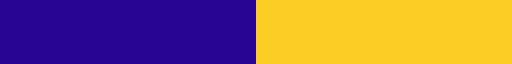

In [3]:
# Define cmap
plasma_seg = seg_cmap(cmap_name='plasma', value_range=(0.05, 0.9), num_colors=256, alpha=1.0, segments=2)
plasma_seg

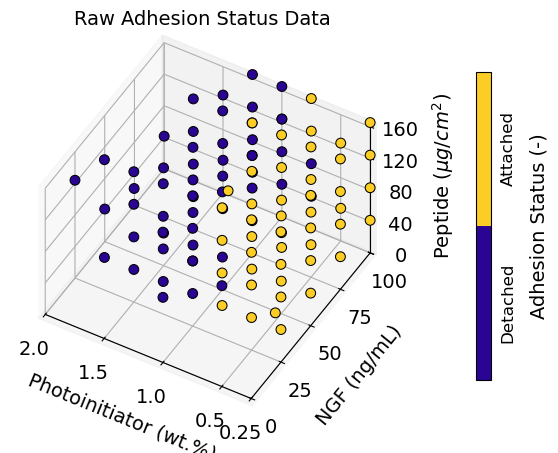

In [4]:
raw_plot = raw_scatter(df_all, azim=120, y_label='Adhesion', cmap=plasma_seg, elev=45, linewidths=0.75, 
                       cbar_label='Adhesion Status (-)', cpad=0.13, labels=True, zticks=[0, 40, 80, 120, 160])
plt.show()

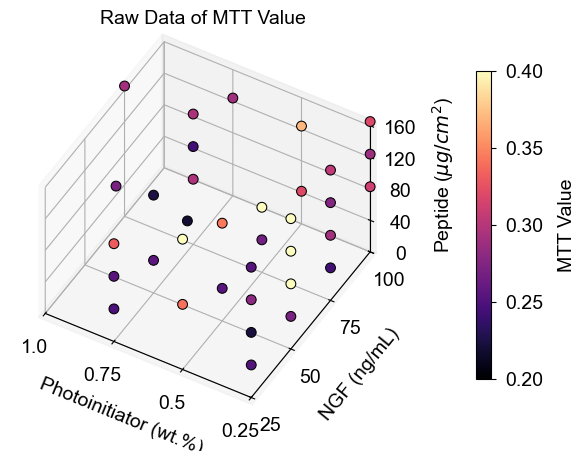

In [5]:
raw_scatter(df_all_att, vmin=0.2, vmax=0.4, azim=120, elev=45, linewidths=0.75, cbar_label='MTT Value', y_label='MTT Value',
            cpad=0.13, cmap='magma', xticks=[0.25, 0.50, 0.75, 1.0], yticks=[25, 50, 75, 100], 
            zticks=[0, 40, 80, 120, 160], cbarticks=[0.2, 0.25, 0.3, 0.35, 0.4], detatch=False, 
            title='Raw Data of MTT Value', labels=True)
plt.show()

## Normalize Data for Training Models

In [6]:
# Normalize x to 0-1 for classification
x_cols = ['PHO (wt.%)', 'NGF (ng/mL)', 'LAM (ug/cm2)']
y_cols = ['Neurite', 'MTT Value']
x_std_cols = ['PHO_std', 'NGF_std', 'LAM_std']
x_std_cols_mtt = ['PHO_std', 'NGF_std', 'LAM_std', 'MTT_std']

from sklearn.preprocessing import MinMaxScaler
scaler_clf = MinMaxScaler()
scaler_mtt = MinMaxScaler()
clf_scaled = scaler_clf.fit_transform(df_all[x_cols])
mlps_x_scaled = scaler_clf.transform(df_all_att[x_cols])
mlps_y_scaled = scaler_mtt.fit_transform(df_all_att[y_cols[1]].values.reshape(-1, 1))
df_std_clf = pd.DataFrame(clf_scaled, columns=x_std_cols)
df_std_clf['Adhesion'] = df_all['Adhesion']
df_std_att = pd.DataFrame(np.column_stack([mlps_x_scaled, mlps_y_scaled]), columns=x_std_cols_mtt)

In [7]:
# Train Test split for SVC
from sklearn.model_selection import RepeatedKFold, GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score

x_cols_std = ['PHO_std', 'NGF_std', 'LAM_std']
y_cols_std = ['Adhesion', 'MTT_std']
X = df_std_clf[x_cols_std]
y = df_std_clf[y_cols_std[0]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=34) # random state 34 is gppd

## Data Augmentation

In [8]:
df_clf_train = pd.concat([X_train, y_train], axis=1)
df_clf_test = pd.concat([X_test, y_test], axis=1)

# 10x for SVM classifier
df_clf_aug_train = data_aug(df_clf_train, features=['PHO_std', 'NGF_std', 'LAM_std'], 
                      y_aug=False, y_label='MTT_std', adhesion=True, num_aug=10, fnoise=0.05, ynoise=0.05, 
                      random_state=1)

# 20x for ensemble MLP
df_att_aug = data_aug(df_std_att, features=['PHO_std', 'NGF_std', 'LAM_std'], 
                   y_aug=True, y_label='MTT_std', adhesion=False, num_aug=20, fnoise=0.05, ynoise=0.05,
                   random_state=1)

## Train SVM Models

In [47]:
import joblib
svc = svm.SVC(C=0.1, gamma=0.1)

noaug_clf2 = svc.fit(X_train, y_train.values)
y_pred_train_noaug = noaug_clf2.predict(X_train)
y_pred_test_noaug = noaug_clf2.predict(X_test)
accuracy_train_noaug = accuracy_score(y_train, y_pred_train_noaug)
accuracy_test_noaug = accuracy_score(y_test, y_pred_test_noaug)
print(f'No augmentation SVC training accuracy = {accuracy_train_noaug:.4f}')
print(f'No augmentation SVC testing accuracy = {accuracy_test_noaug:.4f}')

# SVM with hyperparameter optimization and data augmentation
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': ['scale', 'auto', 0.01, 0.1, 1, 10]
}

svc = svm.SVC()
grid_search = GridSearchCV(estimator=svc, param_grid=param_grid, cv=5, n_jobs=-1)
grid_search.fit(df_clf_aug_train[x_cols_std], df_clf_aug_train[y_cols_std[0]].values)
best_clf = grid_search.best_estimator_
# joblib.dump(best_clf, 'best_svc_model.joblib')
y_pred_train = best_clf.predict(df_clf_aug_train[x_cols_std])
y_pred_test = best_clf.predict(X_test)
accuracy_train = accuracy_score(df_clf_aug_train[y_cols_std[0]], y_pred_train)
accuracy_test = accuracy_score(y_test, y_pred_test)

print(f'With augmentation SVC training accuracy = {accuracy_train:.4f}')
print(f'With augmentation SVC testing accuracy = {accuracy_test:.4f}')

No augmentation SVC training accuracy = 0.5604
No augmentation SVC testing accuracy = 0.4545
With augmentation SVC training accuracy = 0.9870
With augmentation SVC testing accuracy = 0.9091


## Constructing Ensemble ANN

In [48]:
selected_models = {}

idxs = {
    'best_mlps': best_idx,
    'strong_mlps': strong_idx,
    'mid_mlps': mid_idx,
    'weak_mlps': weak_idx
}

for model_name, idx_value in idxs.items():
    selected_models[model_name] = select_ensemble(X, y, idx=idx_value)
    joblib.dump(selected_models[model_name], f'mlps_{model_name}.joblib')

In [49]:
base_MLPs = []
r2_scores = []
maes = {}
X = df_att_aug[x_cols_std]
y = df_att_aug[y_cols_std[1]].values.flatten()
models = ['best_mlps', 'strong_mlps', 'mid_mlps', 'weak_mlps']

for model in models:
    selected_model = selected_models[model]
    maes[model] = []
    for i in range(len(selected_model)):

        selected_model[i].fit(X, y)
        base_MLPs.append(selected_model[i])

        # Calculate the R² score
        y_pred = selected_model[i].predict(X)
        r2 = r2_score(y, y_pred)
        mae = MAE(y, y_pred)
        maes[model].append(mae)

        print(f"Train R² score of {model} {i+1}: {r2:.4f}")
        print(f"  Train MAE of {model}:   {mae:.4f}")
        
    joblib.dump(selected_model, f'mlps_{model}.joblib')
    print((f"  {model} average Train MAE:    {np.mean(maes[model]):.4f}"))

Train R² score of best_mlps 1: 0.1120
  Train MAE of best_mlps:   0.2064
Train R² score of best_mlps 2: 0.1268
  Train MAE of best_mlps:   0.2089
Train R² score of best_mlps 3: 0.1401
  Train MAE of best_mlps:   0.2055
Train R² score of best_mlps 4: 0.5058
  Train MAE of best_mlps:   0.1485
Train R² score of best_mlps 5: 0.9833
  Train MAE of best_mlps:   0.0278
  best_mlps average Train MAE:    0.1594
Train R² score of strong_mlps 1: 0.9807
  Train MAE of strong_mlps:   0.0294
Train R² score of strong_mlps 2: 0.9846
  Train MAE of strong_mlps:   0.0262
Train R² score of strong_mlps 3: 0.9864
  Train MAE of strong_mlps:   0.0234
Train R² score of strong_mlps 4: 0.9843
  Train MAE of strong_mlps:   0.0261
Train R² score of strong_mlps 5: 0.9833
  Train MAE of strong_mlps:   0.0278
  strong_mlps average Train MAE:    0.0266
Train R² score of mid_mlps 1: 0.5006
  Train MAE of mid_mlps:   0.1400
Train R² score of mid_mlps 2: 0.5019
  Train MAE of mid_mlps:   0.1466
Train R² score of mid_ml

In [50]:
import copy
df_gd = grid_3d(cols=x_cols_std, num_points=201)
pred_clf = best_clf.predict(df_gd)
df_gd['clf_pred'] = pred_clf

pred_mlps = {}
models = ['best_mlps', 'strong_mlps', 'mid_mlps', 'weak_mlps']

for model in models:
    pred_mlps[model] = MLPs_predict(df_gd.loc[:,x_std_cols], models=selected_models[model])    
    df_gd[f'{model}_pred'] = pred_mlps[model]

df_pred = copy.deepcopy(df_gd)

In [51]:
# For clf heatmap
df_pred_denorm_clf = pd.DataFrame(scaler_clf.inverse_transform(df_pred.loc[:,x_cols_std]), columns=x_cols)
df_pred_denorm_clf['clf_predict'] = df_pred['clf_pred']

# For MTT heatmap
temp_x = scaler_clf.inverse_transform(df_pred.loc[:,x_cols_std])
mlps_pred_cols = df_pred.columns[4:]
temp_y = scaler_mtt.inverse_transform(df_pred.loc[:,mlps_pred_cols].values.reshape(-1, 4))
df_pred_denorm_mlps = pd.DataFrame(np.column_stack([temp_x, temp_y]), columns=x_cols + mlps_pred_cols.to_list())

## Plot Predicted Results via 3D Heatmaps

<Figure size 640x480 with 0 Axes>

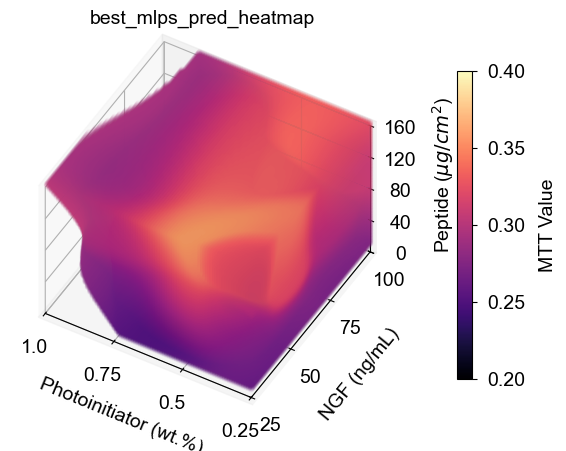

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

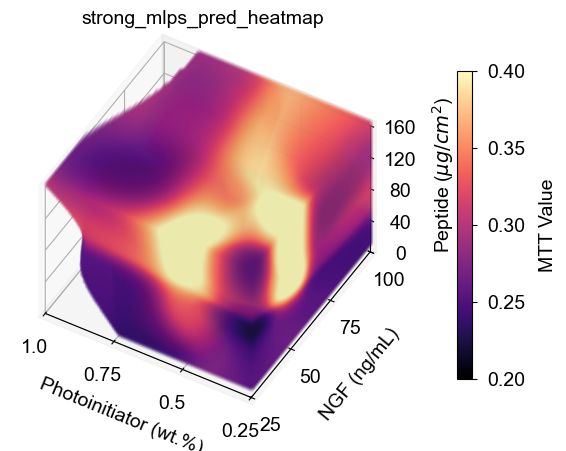

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

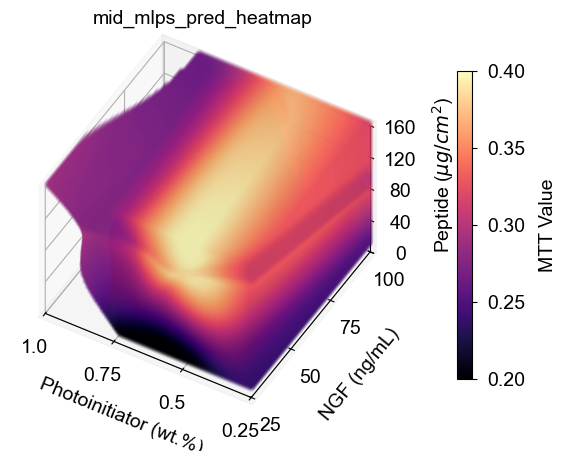

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

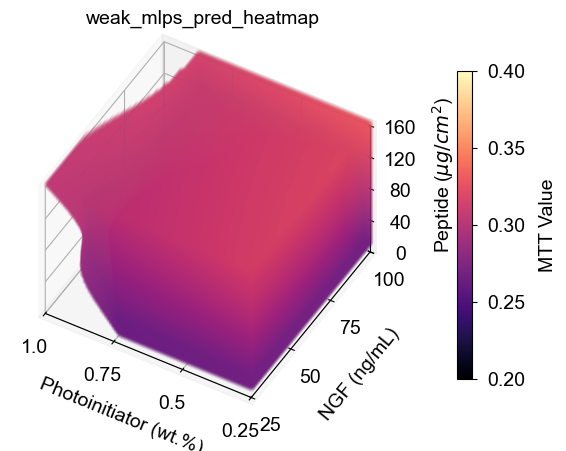

<Figure size 640x480 with 0 Axes>

In [52]:
mask = (df_pred_denorm_clf['clf_predict'] == True)
df_pred_denorm_mlps_m = df_pred_denorm_mlps[mask]
df_pred_denorm_mlps_filtered = df_pred_denorm_mlps_m[(df_pred_denorm_mlps_m['PHO (wt.%)'] <= 1.001) & (df_pred_denorm_mlps_m['NGF (ng/mL)'] >= 24.999) & (df_pred_denorm_mlps_m['LAM (ug/cm2)'] >= 10.299)]
y_labels = df_pred_denorm_mlps.columns.to_list()[3:]

for label in y_labels:
    plt.figure()
    raw_scatter(df_pred_denorm_mlps_filtered, vmin=0.2, vmax=0.4, features=x_cols, y_label=label, s=20, alpha=0.05, 
                marker='o', edgecolor='none', cbar_label='MTT Value', xticks=[0.25, 0.50, 0.75, 1.0], yticks=[25, 50, 75, 100], 
                zticks=[0, 40, 80, 120, 160], cbarticks=[0.2, 0.25, 0.3, 0.35, 0.4], labels=True,
                linewidths=0, cmap='magma', azim=120, elev=45, title=f'{label}_heatmap', detatch=False, cbar_alpha=1.0,
                )
    plt.show()
    plt.clf()

## Plot 2D Heatmaps for Best Models

In [53]:
from tqdm.auto import tqdm
import copy
import warnings
warnings.simplefilter("ignore", UserWarning)

n_points = 1001

xyz_columns = [
    ('PHO (wt.%)', 0.25, 1.0, [0.25, 0.50, 0.75, 1.0]),
    ('NGF (ng/mL)',   25, 100, [  25,   50,   75, 100]),
    ('LAM (ug/cm2)',    10.3, 165.3, [   10.3,  40,  80, 120, 160])
]

slices = [
    ('PHO (wt.%)', 0.5),
    ('NGF (ng/mL)', 75),
    ('LAM (ug/cm2)', 80),
]


pred_packages = {}

for slice_col, slice_val in tqdm(slices):
    (x_col, x_min, x_max, x_ticks), (y_col, y_min, y_max, y_ticks) = [info for info in xyz_columns if info[0] != slice_col]
    _x = np.linspace(x_min, x_max, num=n_points)
    _y = np.linspace(y_min, y_max, num=n_points)
    xx, yy = np.meshgrid(_x, _y)
    
    pred_df = pd.DataFrame()
    pred_df[x_col] = xx.reshape(-1)
    pred_df[y_col] = yy.reshape(-1)
    pred_df[slice_col] = slice_val
    pred_df = pred_df[x_cols]
    pred_df['Pred_Adhesion'] = best_clf.predict(scaler_clf.transform(pred_df[x_cols]))
    pred_df['Pred_MTT'] = MLPs_predict(scaler_clf.transform(pred_df[x_cols]), models=selected_models['best_mlps'])
    pred_df['Pred_MTT'] = scaler_mtt.inverse_transform(pred_df['Pred_MTT'].values.reshape(-1, 1))
    
    pred_packages[(slice_col, slice_val)] = (xx, yy, pred_df)    

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:30<00:00, 10.13s/it]


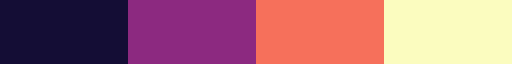

In [54]:
magma_seg = seg_cmap(cmap_name='magma', value_range=(0.1, 1.0), num_colors=256, alpha=1.0, segments=4)
magma_seg

100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 53.01it/s]


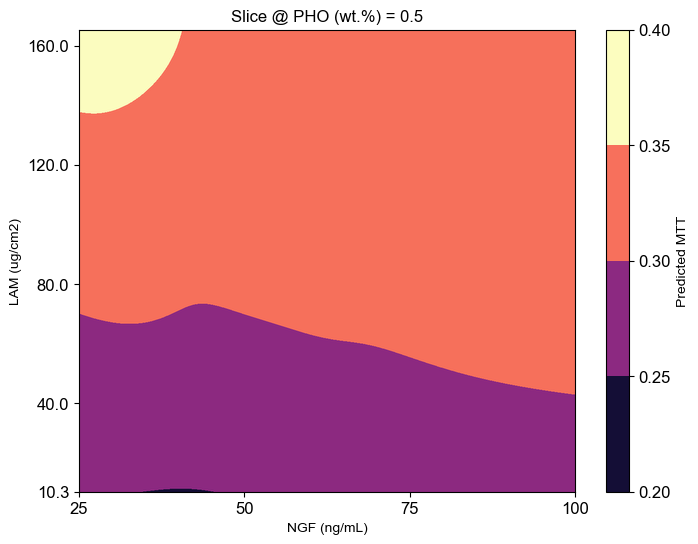

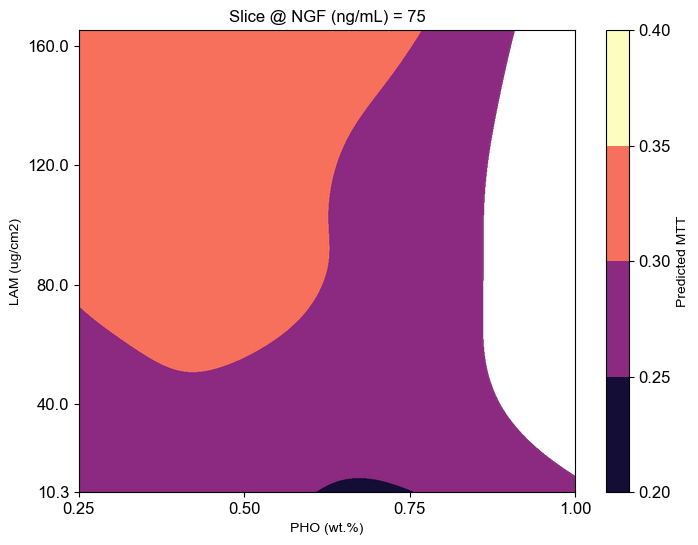

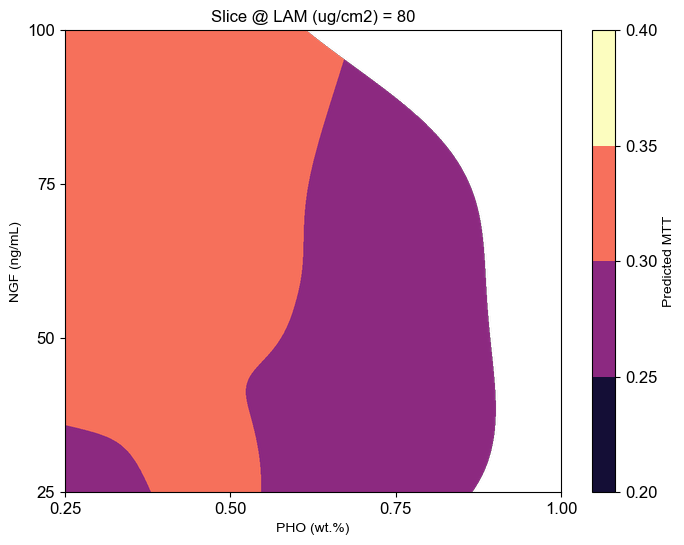

In [55]:
for slice_col, slice_val in tqdm(slices):
    (x_col, x_min, x_max, x_ticks), (y_col, y_min, y_max, y_ticks) = [info for info in xyz_columns if info[0] != slice_col]
    xx, yy, pred_df = pred_packages[(slice_col, slice_val)]

    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    cc = copy.deepcopy(pred_df['Pred_MTT'].values).reshape(xx.shape)
    mask = pred_df['Pred_Adhesion'].values.reshape(xx.shape).astype(bool)
    cc[~mask] = np.nan

    im = ax.imshow(cc, cmap=magma_seg, vmin=0.2, vmax=0.4, aspect='auto',
              origin='lower', extent=(x_min, x_max, y_min, y_max), 
              interpolation='lanczos', interpolation_stage='rgba',
             )

    ax.set_xlabel(x_col)
    ax.set_ylabel(y_col)
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(x_ticks)
    ax.set_yticks(y_ticks)
    ax.set_title(f'Slice @ {slice_col} = {slice_val}')
    ax.tick_params(axis='both', which='both', labelsize=12)

    cbar = plt.colorbar(im, ax=ax)
    cbar.set_label('Predicted MTT')
    cbar.set_ticks([0.2, 0.25, 0.3, 0.35, 0.4])
    cbar.ax.tick_params(labelsize=12)
    # fig.savefig(f'110124_slicevar_mix5_{slice_val}_2.png', dpi=300)

## Spearman's Analysis

In [56]:
from scipy.stats import spearmanr
import seaborn as sns

raw_x_cols = ['PHO (wt.%)', 'NGF (ng/mL)', 'LAM (ug/cm2)']

for df, y_col in [(df_all, 'Adhesion'), (df_all_att, 'MTT Value')]:
    print(spearmanr(df[raw_x_cols + [y_col]]))

raw_x_cols = ['PHO (wt.%)', 'NGF (ng/mL)', 'LAM (ug/cm2)']
r_x_cols = raw_x_cols[::-1]
p_color  = '#1F4D7D'
ax_color = 'k'

p_min = 0.001
r_min = 0.45

n_xcols = len(r_x_cols)
x_ticks = np.linspace(1, n_xcols, n_xcols)
x_lo, x_hi = 0.5, n_xcols + 0.5
bar_height = 0.3

def style_corr_bar(ax, legend_ncol=1, ):
    ax.plot([0, 0], [-1, n_xcols + 1],  linestyle='-', color=ax_color, lw=0.5)
    ax.plot([r_min, r_min], [-1, n_xcols + 1],  linestyle='--', color='grey', lw=0.5)
    ax.plot([-r_min, -r_min], [-1, n_xcols + 1],  linestyle='--', color='grey', lw=0.5)
    ax.set_xlabel('spearman $r$')
    ax.set_xticks([-1, -.5, 0, .5, 1])
    ax.set_xticklabels(['-1', '-0.5', '0', '0.5', '1'])
    ax.tick_params(axis='x', which='both')
    ax.set_xlim(-1, 1)
    ax.set_ylim(x_lo, x_hi)
    ax.set_yticks(x_ticks)
    ax.set_yticklabels(r_x_cols)
    ax.minorticks_off()
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.2), ncol=legend_ncol, fancybox=False, shadow=False)
    # fig.tight_layout()

SignificanceResult(statistic=array([[ 1.        , -0.04481901, -0.02672828, -0.84040643],
       [-0.04481901,  1.        , -0.04367758,  0.01204484],
       [-0.02672828, -0.04367758,  1.        ,  0.04034475],
       [-0.84040643,  0.01204484,  0.04034475,  1.        ]]), pvalue=array([[0.00000000e+00, 6.54661345e-01, 7.89728576e-01, 2.35000402e-28],
       [6.54661345e-01, 0.00000000e+00, 6.62914057e-01, 9.04362724e-01],
       [7.89728576e-01, 6.62914057e-01, 0.00000000e+00, 6.87239445e-01],
       [2.35000402e-28, 9.04362724e-01, 6.87239445e-01, 0.00000000e+00]]))
SignificanceResult(statistic=array([[ 1.        ,  0.00167862, -0.01550402, -0.17493796],
       [ 0.00167862,  1.        , -0.0013374 ,  0.15359982],
       [-0.01550402, -0.0013374 ,  1.        ,  0.39238288],
       [-0.17493796,  0.15359982,  0.39238288,  1.        ]]), pvalue=array([[0.        , 0.99236423, 0.92956108, 0.31483012],
       [0.99236423, 0.        , 0.99391636, 0.37834425],
       [0.92956108, 0.993916

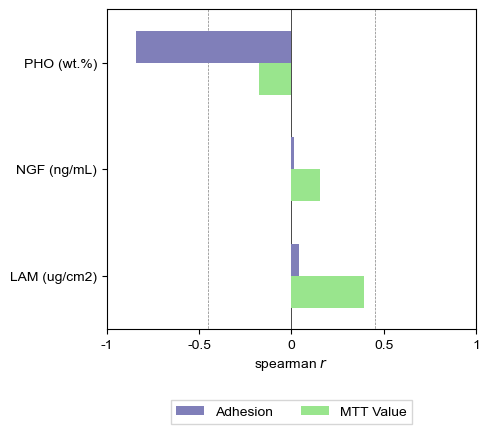

In [57]:
from scipy.stats import spearmanr
import seaborn as sns

fig, ax = plt.subplots(1, 1, figsize=(5, 4.5))

for i, (df, y_col, color) in enumerate([(df_all, 'Adhesion', '#807FB9', ), (df_all_att, 'MTT Value', '#99E58D', )]):
    corr = df[r_x_cols].corrwith(df[y_col], method='spearman')
    bars = ax.barh(x_ticks - (i - 0.5) * bar_height, corr, align='center', height=bar_height, color=color, label=y_col, zorder=300)

style_corr_bar(ax, legend_ncol=2, )
fig.tight_layout()


In [58]:
# face = df_adh_pred[df_adh_pred['PHO (wt.%)'] == 0.25]
# xf =  face['NGF (ng/mL)']
# yf = face['LAM (ug/mL)']
# cf = face['Prediction_adhesion']

# fig = plt.figure(figsize=(8, 6))
# ax = fig.add_subplot(1, 1, 1)
# scf = ax.scatter(xf, yf, c=cf, cmap=magma_seg, s=10, marker='.')

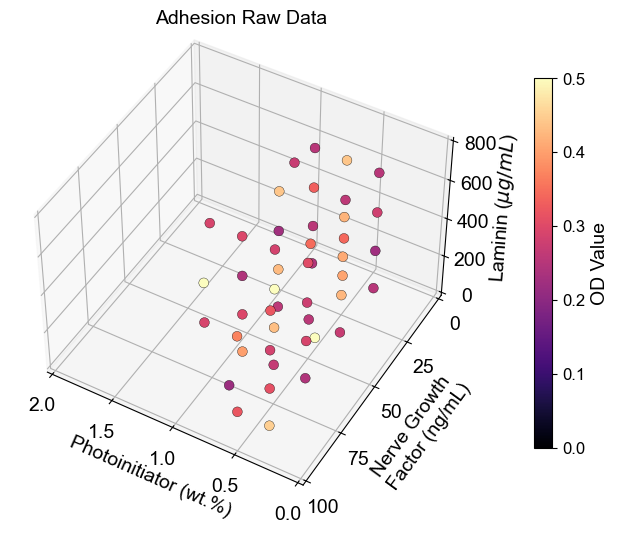

In [76]:
# Raw scatter plot
raw_adh_plot = raw_scatter_OD(df_adh, y_label='OD Value', cmap='magma', vmax=0.5, azim=120, elev=45, show_cbar=True, cbar_label='OD Value')
raw_adh_plot = plt.gcf()
filepath = os.path.join(r"C:\Users\s5575\OneDrive\Documents\Po-Yen Chen related\US\ECL_Project\Figures", "raw_scatter_adh.png")
raw_adh_plot.savefig(filepath, dpi=300)

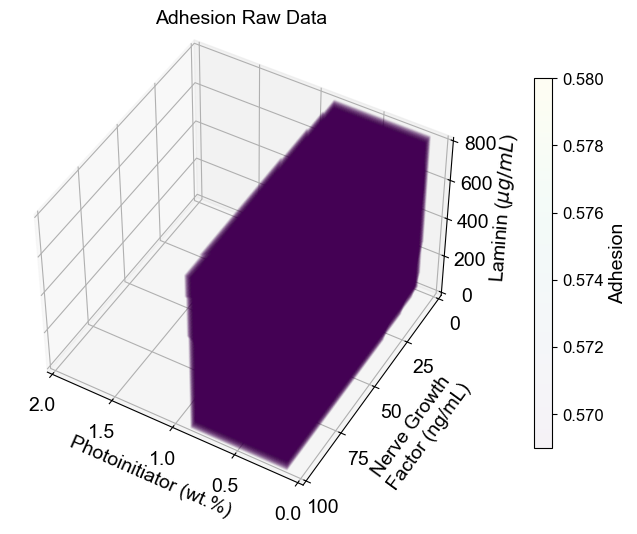

In [350]:
adh_heat_svr = heatmap_svr(df_adh_pred_svr, y_label='Predicted OD', s=15, cmap='viridis', alpha=0.05, vmin=0.569, vmax=0.58, marker='.', edgecolor='none', linewidths=0, azim=120, elev=45)

In [351]:
df_adh_pred_svr

,PHO (wt.%),NGF (ng/mL),LAM (ug/mL),Prediction_adhesion,Predicted OD
0,0.122222,0.035,0.680,1,0.579381
1,0.122222,0.035,0.685,1,0.579381
2,0.122222,0.035,0.690,1,0.579381
3,0.122222,0.035,0.695,1,0.579381
4,0.122222,0.035,0.700,1,0.579381
...,...,...,...,...,...
3172658,1.000000,0.885,0.995,1,0.579381
3172659,1.000000,0.885,1.000,1,0.579381
3172660,1.000000,0.890,0.995,1,0.579381
3172661,1.000000,0.890,1.000,1,0.579381


In [28]:
import tensorflow as tf
from tensorflow.python import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

# Spare ANN model with 5 hidden layers and NO DATA AUGMENTATION
def ann_NoDA():
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(0)

    # Create a simple ANN model for regression
    model2 = Sequential()
    model2.add(Dense(64, 
        activation='relu', 
        kernel_initializer='he_uniform', 
        kernel_regularizer=regularizers.L1L2(l1=1e-2, l2=1e-4),
        input_shape=(3,))) # 3 for 3 features
    
    for _ in range(4):
        model2.add(Dense(64, 
        activation='relu', 
        kernel_initializer='he_uniform', 
        kernel_regularizer=regularizers.L1L2(l1=1e-2, l2=1e-4)))
        
    model2.add(Dense(1, activation='linear'))
    # model2.add(keras.layers.preprocessing.image_preprocessing.Rescaling(100.0))

    # Compile the model
    model2.compile(optimizer=Adam(learning_rate=1e-5), loss='mae', metrics=['mae'])
    
    return model2

In [31]:
# Train the model
model2 = ann_NoDA()
history_test = model2.fit(x_neurite_train, 
                         y_neurite_train, epochs=500, 
                         batch_size=8, 
                         verbose=1, 
                         validation_data=(x_neurite_test, y_neurite_test), 
                         validation_batch_size=16)

Epoch 1/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 26.7356 - mae: 0.3985 - val_loss: 26.7051 - val_mae: 0.3739
Epoch 2/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.7159 - mae: 0.3863 - val_loss: 26.6797 - val_mae: 0.3559
Epoch 3/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.6969 - mae: 0.3748 - val_loss: 26.6543 - val_mae: 0.3380
Epoch 4/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.6780 - mae: 0.3634 - val_loss: 26.6291 - val_mae: 0.3203
Epoch 5/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.6593 - mae: 0.3522 - val_loss: 26.6046 - val_mae: 0.3034
Epoch 6/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.6408 - mae: 0.3412 - val_loss: 26.5803 - val_mae: 0.2865
Epoch 7/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.6225 - mae: 0.3304 - val_loss: 26.5562 - val_mae: 0.2700
Epoch 8/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.6046 - mae: 0.3200 - val_loss: 26.5326 - val_mae: 0.2539
Epoch 9/500
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 26.587

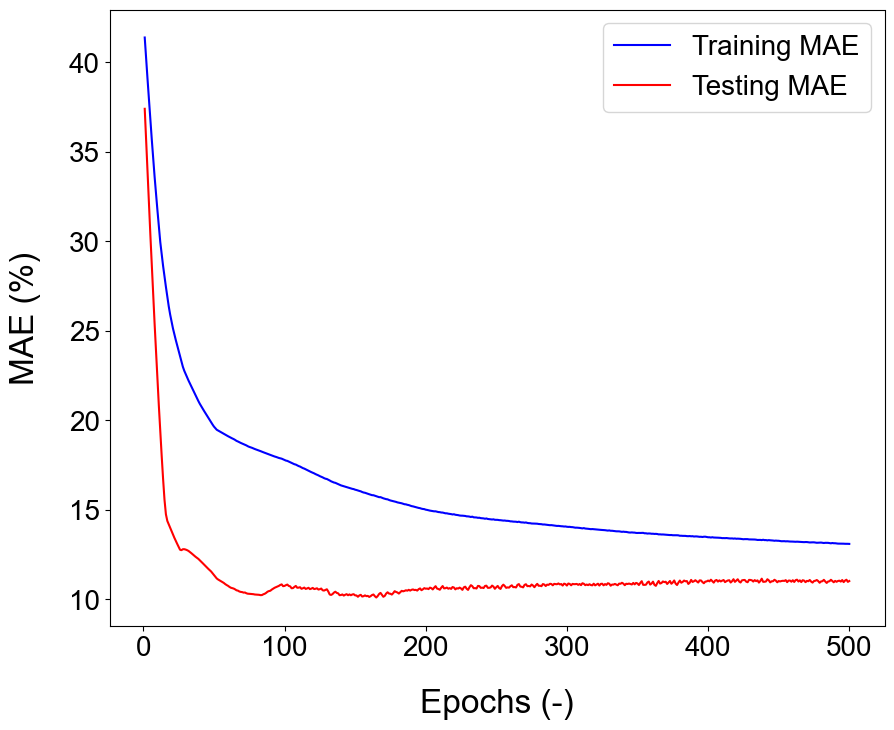

In [32]:
# Extract training and validation MAE from the history object
train_mae = [x * 100 for x in history_test.history['mae']]
val_mae = [x * 100 for x in history_test.history['val_mae']]
epochs = range(1, len(train_mae) + 1)

# Plot the training and validation MAE
plt.figure(figsize=(10, 8))
plt.plot(epochs, train_mae, 'b', label='Training MAE')
plt.plot(epochs, val_mae, 'r', label='Testing MAE')
plt.xlabel('Epochs (-)', fontsize=24, fontname='Arial', labelpad=20)
plt.ylabel('MAE (%)', fontsize=24, fontname='Arial', labelpad=20)
plt.xticks(fontsize=20, fontname='Arial')
plt.yticks(fontsize=20, fontname='Arial')
plt.legend(prop={'family':'Arial', 'size':20})
# plt.savefig('112823_ECL_MAE.png', dpi=300, format='png')

In [35]:
ann_pred = model2.predict(df_adh_pred_svr[x_cols])

99146/99146 ━━━━━━━━━━━━━━━━━━━━ 42s 422us/step


array([[0.34996155],
       [0.35182387],
       [0.35368592],
       ...,
       [0.5859089 ],
       [0.5852    ],
       [0.5887984 ]], dtype=float32)

In [41]:
df_adh_pred_svr['ANN Prediction'] = ann_pred
df_adh_pred_svr.max()

PHO (wt.%)             1.000000
NGF (ng/mL)            1.000000
LAM (ug/mL)            1.000000
Prediction_adhesion    1.000000
Predicted OD           0.589389
ANN Prediction         1.008613
dtype: float64

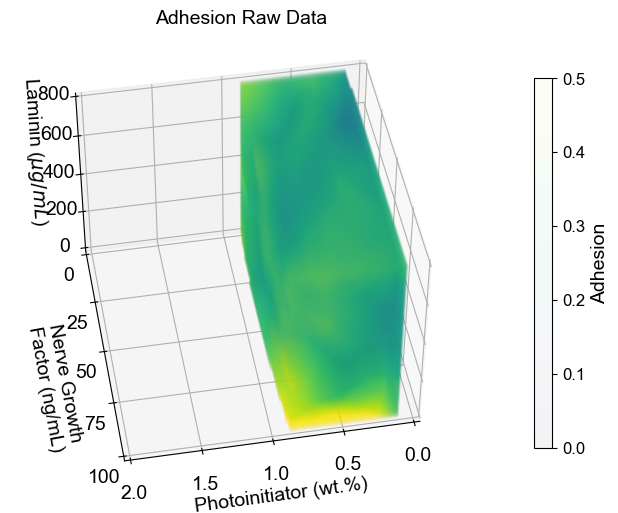

In [45]:
adh_heat_ann = heatmap_svr(df_adh_pred_svr[df_adh_pred_svr['ANN Prediction'] >= 0.3], y_label='ANN Prediction', s=15, cmap='viridis', alpha=0.05, vmin=0, vmax=0.5, marker='.', edgecolor='none', linewidths=0, azim=80, elev=45)

In [210]:
# Scatter plot
def raw_scatter_norm(df, y_label='Neurite',vmin=0.0, vmax=0.5, marker='o', linewidths=0.25, s=50, alpha=1, 
                elev=45, azim=30, edgecolor='k', cmap='viridis', show_cbar=True, cbar_label='Adhesion', pad=0.1):
     
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    x, y, z, c = df['PHO (wt.%)'], df['NGF (ng/mL)'], df['LAM (ug/mL)'], df[y_label]
        
    # Scatter Plot
    sc1 = ax.scatter(x, y, z, c=c, cmap=cmap, s=s,  vmin=vmin, vmax=vmax, marker=marker, 
                    linewidths=linewidths, alpha=alpha, edgecolor=edgecolor)

    if show_cbar == True:
        cbar = plt.colorbar(sc1, shrink=0.8, pad=pad)
        cbar.ax.tick_params(labelsize=12)
        cbar.set_label(cbar_label, size=14)
        # cbar.set_ticks([0, 0.25, 0.5, 0.75, 1.0])
        # cbar.set_ticklabels([np.linspace(vmin, vmax, 5)])
    
    plt.rcParams["font.family"] = "Arial"
    plt.title(f'Adhesion Raw Data', fontsize=14)
    ax.view_init(elev=elev, azim=azim)
    # ax.set_xlim(0.00, 2.00)
    # ax.set_ylim(0, 100)
    # ax.set_zlim(0, 800)
    # ax.set_xticks([0.00, 0.50, 1.00, 1.50, 2.00])
    # ax.set_yticks([0, 25, 50, 75, 100])
    # ax.set_zticks([0, 200, 400, 600, 800])
    # ax.set_xticklabels([0.00, 0.50, 1.00, 1.50, 2.00], fontsize=14)
    # ax.set_yticklabels([0, 25, 50, 75, 100], fontsize=14)
    # ax.set_zticklabels([0, 200, 400, 600, 800], fontsize=14)
    ax.set_xlabel('Photoinitiator (wt.%)', fontsize=14)
    ax.set_ylabel('Nerve Growth\n Factor (ng/mL)', fontsize=14, labelpad=10)
    ax.set_zlabel(r"Laminin ($\mu g/mL$)", fontsize=14)
    
    return sc1

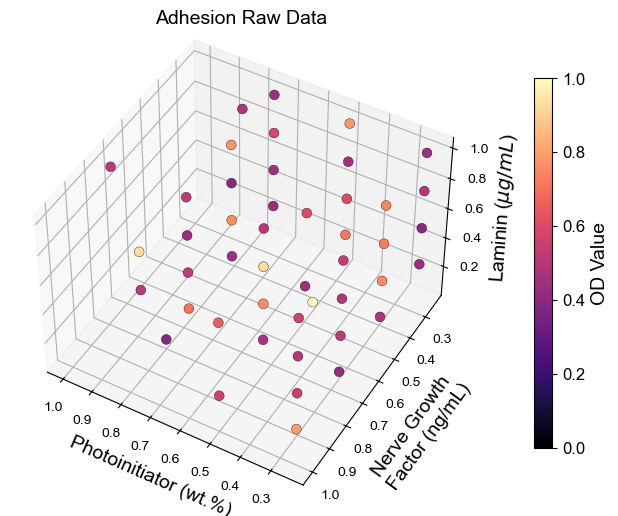

In [213]:
raw_adh_plot = raw_scatter_norm(df_adh_norm, y_label='Scaled OD Value', cmap='magma', vmax=1.0, azim=120, elev=45, show_cbar=True, cbar_label='OD Value')

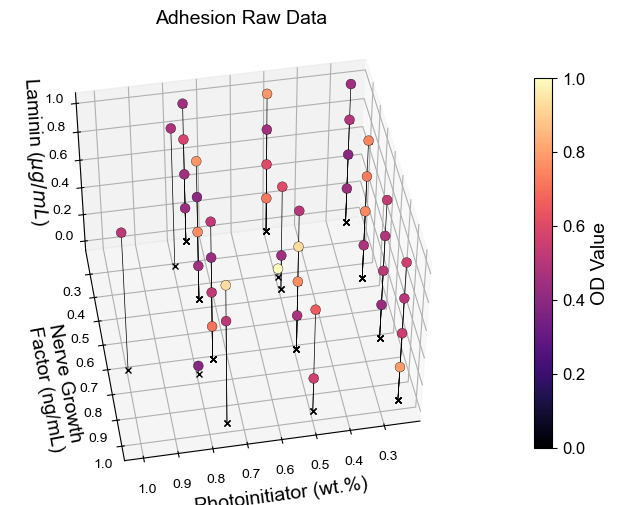

In [258]:
raw_adh_plot = raw_scatter_norm(df_adh_norm, y_label='Scaled OD Value', cmap='magma', vmax=1.0, azim=80, elev=45, show_cbar=True, cbar_label='OD Value')
x=np.array([df_adh_norm[x_cols[0]],df_adh_norm[x_cols[0]]]).T
y=np.array([df_adh_norm[x_cols[1]],df_adh_norm[x_cols[1]]]).T
z=np.array([df_adh_norm[x_cols[2]],df_adh_norm[x_cols[2]]]).T
z[:,0]=0
for ii in range(46):
    plt.plot(x[ii],y[ii],z[ii],'kx-',markersize=5,linewidth=0.5)
#df_adh_norm[x_cols]

In [ ]:
grid_x, grid_y, grid_z = np.mgrid[0:1:101j, 0:1:101j, 0:1:101j]


In [264]:
from scipy.interpolate import interpn
grid_z0 = interpn(df_adh_norm[x_cols], df_adh_norm['Scaled OD Value'].values.flatten(), (grid_x, grid_y, grid_z), method='cubic')
plt.imshow(grid_z0.T, extent=(0,1,0,1,0,1), origin='lower')
plt.title('Cubic')

ValueError: Unknown interpolation method 'cubic' for 3 dimensional data

In [ ]:
from scipy.interpolate import LinearNDInterpolator
x = df_adh['PHO (wt.%)'].values.flatten()
y = df_adh['NGF (ng/mL)'].values.flatten()
z = df_adh['LAM (ug/mL)'].values.flatten()
values = df_adh['OD Value'].values.flatten()

X = np.linspace(min(x), max(x), 51)
Y = np.linspace(min(y), max(y), 51)
Z = np.linspace(min(z), max(z), 51)
X, Y, Z = np.meshgrid(X, Y, Z)
interp = LinearNDInterpolator(list(zip(x, y, z)), values)

interp_values = interp(X, Y, Z)


Text(0.5, 0, 'LAM (ug/mL)')

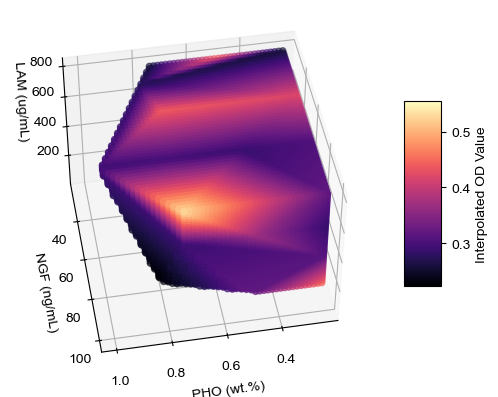

In [285]:
# Create a figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=45, azim=80)

# Plot the scatter points with interpolated values
scat = ax.scatter(X, Y, Z, c=interp_values, cmap='magma',)

# Add color bar which maps values to colors
cbar = plt.colorbar(scat, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Interpolated OD Value')

# Labeling the axes
ax.set_xlabel('PHO (wt.%)')
ax.set_ylabel('NGF (ng/mL)')
ax.set_zlabel('LAM (ug/mL)')


In [271]:
df_adh_sorted = df_adh.sort_values(by=['PHO (wt.%)', 'NGF (ng/mL)', 'LAM (ug/mL)', 'OD Value'])
df_adh_sorted
                                

,PHO (wt.%),NGF (ng/mL),LAM (ug/mL),membrane,OD Value,Neurite
9,0.25,25,200,1,0.251,1
10,0.25,25,400,1,0.223,1
11,0.25,25,600,1,0.280,1
12,0.25,25,800,1,0.253,1
13,0.25,50,200,1,0.270,1
19,0.25,50,400,1,0.425,1
20,0.25,50,600,1,0.412,1
21,0.25,50,800,1,0.421,1
14,0.25,75,200,1,0.243,1
15,0.25,75,400,1,0.290,1


In [3]:
# Filter rows with 0 MTT value
# No0MTT = batch_all[batch_all["MTT"] != 0]

# Select columns for SVR
x_cols = ["PHO (wt.%)", "NGF (ng/mL)", "LAM (ug/mL)"]
y_cols = ["OD Value"]

# Split data for SVR
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(batch_all[x_cols], batch_all[y_cols], test_size=0.2, random_state=0)


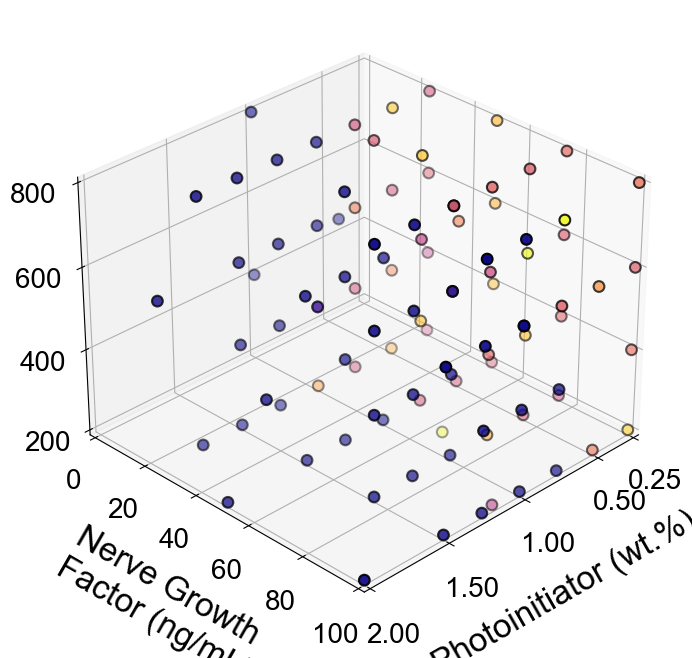

In [7]:
# rcParams.update({'figure.autolayout': True})
plt.rcParams['font.family'] = 'Arial'
fig_raw = plt.figure(figsize=(10,8))
ax = fig_raw.add_subplot(111, projection='3d')
sc = ax.scatter(batch_all['PHO (wt.%)'], batch_all['NGF (ng/mL)'], batch_all['LAM (ug/mL)'], vmax=0.5, c=batch_all['OD Value'], cmap='plasma', s=60, linewidths=1.5, edgecolors='k')
ax.set_xlabel("Photoinitiator (wt.%)", fontsize=24, labelpad=25)
ax.set_ylabel("Nerve Growth\n Factor (ng/mL)", fontsize=24, labelpad=30)
ax.set_zlabel("Peptide ($\mu$g/mL)", fontsize=24, labelpad=25)
ax.set_xlim(0.25, 2.0)
ax.set_ylim(0, 100)
ax.set_zlim(200, 800)
ax.set_xticks([0.25, 0.50, 1.00, 1.50, 2.00])
ax.set_yticks([0, 20, 40, 60, 80, 100])
ax.set_zticks([200, 400, 600, 800])
ax.tick_params(axis="x", labelsize=20, pad=10)
ax.tick_params(axis="y", labelsize=20, pad=10)
ax.tick_params(axis="z", labelsize=20, pad=10)
ax.view_init(elev=30, azim=45)

# # Create colorbar
# colorbar_position = [0.95, 0.2, 0.025, 0.6]
# cax = fig_raw.add_axes(colorbar_position)
# cbar = fig_raw.colorbar(sc, cax=cax)
# cbar.set_label('MTT Value (-)', fontsize=24, labelpad=10)
# cbar.ax.tick_params(labelsize=20)

# fig_raw.subplots_adjust(left=1.0, right=2.0, bottom=0.5, top=0.6)
plt.savefig("1109_Raw_Scatter.png", dpi=300, bbox_inches="tight", pad_inches=1.0)

In [4]:
scalerx = np.max(x_train, axis=0) # Divide each x column's max value
x_train_normalized = x_train / scalerx
x_test_normalized = x_test / scalerx

In [23]:
len(x_test_normalized)

21

In [7]:
# # Define a grid of hyperparameter ranges
# param_grid = {'C': np.logspace(-1, 2, num=100), 
#               'gamma': np.logspace(0, -4, num=100), 
#               'kernel': ['rbf', 'poly', 'sigmoid']} 

# # Initialize a GridSearchCV object
# grid = GridSearchCV(SVR(), param_grid, refit=True, verbose=0, scoring='neg_mean_absolute_error')

# # Fit the grid search to the data
# y_train_1d = np.array(y_train)
# grid.fit(x_train_normalized, y_train_1d.ravel())

# # Get the optimal parameters
# print(grid.best_estimator_)

SVR(C=4.641588833612779, gamma=1.0)


In [8]:
# Define the model
svr = SVR(kernel='rbf', C=4.64, gamma=1.0)  # Best parameters according to GridSearchCV()

In [9]:
# Traing SVR model
svr.fit(x_train_normalized, y_train_1d.ravel())

SVR(C=4.64, gamma=1.0)

In [10]:
# Make predictions on the training data and calculate MAE
y_train_pred = svr.predict(x_train_normalized)
mae_train = mean_absolute_error(y_train, y_train_pred)
print(f"MAE on training data: {mae_train}")

MAE on training data: 0.07802381896181403


In [11]:
# Make predictions on the testing data and calculate MAE
y_test_pred = svr.predict(x_test_normalized)
mae_test = mean_absolute_error(y_test, y_test_pred)
print(f"MAE on testing data: {mae_test}")

MAE on testing data: 0.09831503557302224


In [ ]:
y_test_ravel = np.ravel(y_test)
y_test_pred_ravel = np.ravel(y_test_pred)
df = pd.DataFrame({'Test Value': y_test_ravel, 'Prediction': np.round(y_test_pred_ravel, 3)})
plt.scatter(df['Test Value'], df['Prediction'])
ax = plt.gca()
ax.set_xticks(np.linspace(0, 0.6, 7))
ax.set_yticks(np.linspace(-0.2, 0.6, 9))
plt.show()
df

In [5]:
# Spare ANN model with 10 hidden layers
def ann():
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(0)

    # Create a simple ANN model for regression
    model = Sequential()
    model.add(keras.layers.Input(3)) # 3 for 3 features
    model.add(keras.layers.GaussianNoise(1/20))
    for _ in range(10):
        model.add(Dense(64, 
        activation='relu', 
        kernel_initializer='he_uniform', 
        kernel_regularizer=keras.regularizers.L1L2(l1=1e-2, l2=1e-4))) 
    model.add(Dense(1, activation='linear'))
    # model2.add(keras.layers.preprocessing.image_preprocessing.Rescaling(100.0))

    # Compile the model
    model.compile(optimizer=Adam(learning_rate=1e-5), loss='mae', metrics=['mae'])
    
    return model

In [10]:
# Spare ANN model with 10 hidden layers and NO DATA AUGMENTATION
def ann_NoDA():
    tf.keras.backend.clear_session()
    tf.keras.utils.set_random_seed(0)

    # Create a simple ANN model for regression
    model2 = Sequential()
    model2.add(keras.layers.Input(3)) # 3 for 3 features
    # model2.add(keras.layers.GaussianNoise(1/200))
    for _ in range(5):
        model2.add(Dense(64, 
        activation='relu', 
        kernel_initializer='he_uniform', 
        kernel_regularizer=keras.regularizers.L1L2(l1=1e-2, l2=1e-4))) 
    model2.add(Dense(1, activation='linear'))
    # model2.add(keras.layers.preprocessing.image_preprocessing.Rescaling(100.0))

    # Compile the model
    model2.compile(optimizer=Adam(learning_rate=1e-5), loss='mae', metrics=['mae'])
    
    return model2

In [7]:
# Train the model
model = ann()
history_test = model.fit(x_train_normalized, 
                         y_train, epochs=500, 
                         batch_size=8, 
                         verbose=1, 
                         validation_data=(x_test_normalized, y_test), 
                         validation_batch_size=16)

Epoch 1/500
11/11 [==============================] - 2s 45ms/step - loss: 58.2101 - mae: 0.3825 - val_loss: 58.1357 - val_mae: 0.3267
Epoch 2/500
11/11 [==============================] - 0s 6ms/step - loss: 58.1356 - mae: 0.3398 - val_loss: 58.0642 - val_mae: 0.2870
Epoch 3/500
11/11 [==============================] - 0s 6ms/step - loss: 58.0776 - mae: 0.3136 - val_loss: 57.9990 - val_mae: 0.2537
Epoch 4/500
11/11 [==============================] - 0s 6ms/step - loss: 58.0152 - mae: 0.2831 - val_loss: 57.9349 - val_mae: 0.2215
Epoch 5/500
11/11 [==============================] - 0s 6ms/step - loss: 57.9580 - mae: 0.2579 - val_loss: 57.8765 - val_mae: 0.1950
Epoch 6/500
11/11 [==============================] - 0s 6ms/step - loss: 57.8984 - mae: 0.2302 - val_loss: 57.8239 - val_mae: 0.1744
Epoch 7/500
11/11 [==============================] - 0s 6ms/step - loss: 57.8524 - mae: 0.2163 - val_loss: 57.7745 - val_mae: 0.1571
Epoch 8/500
11/11 [==============================] - 0s 6ms/step - l

In [11]:
# Train the model
model2 = ann_NoDA()
history_test = model2.fit(x_train_normalized, 
                         y_train, epochs=500, 
                         batch_size=8, 
                         verbose=1, 
                         validation_data=(x_test_normalized, y_test), 
                         validation_batch_size=16)

Epoch 1/500
11/11 [==============================] - 1s 25ms/step - loss: 27.0704 - mae: 0.7371 - val_loss: 27.0504 - val_mae: 0.7249
Epoch 2/500
11/11 [==============================] - 0s 5ms/step - loss: 27.0232 - mae: 0.7033 - val_loss: 27.0038 - val_mae: 0.6916
Epoch 3/500
11/11 [==============================] - 0s 5ms/step - loss: 26.9782 - mae: 0.6717 - val_loss: 26.9585 - val_mae: 0.6597
Epoch 4/500
11/11 [==============================] - 0s 5ms/step - loss: 26.9348 - mae: 0.6417 - val_loss: 26.9133 - val_mae: 0.6280
Epoch 5/500
11/11 [==============================] - 0s 5ms/step - loss: 26.8911 - mae: 0.6114 - val_loss: 26.8699 - val_mae: 0.5980
Epoch 6/500
11/11 [==============================] - 0s 5ms/step - loss: 26.8492 - mae: 0.5828 - val_loss: 26.8285 - val_mae: 0.5700
Epoch 7/500
11/11 [==============================] - 0s 5ms/step - loss: 26.8071 - mae: 0.5541 - val_loss: 26.7881 - val_mae: 0.5430
Epoch 8/500
11/11 [==============================] - 0s 5ms/step - l

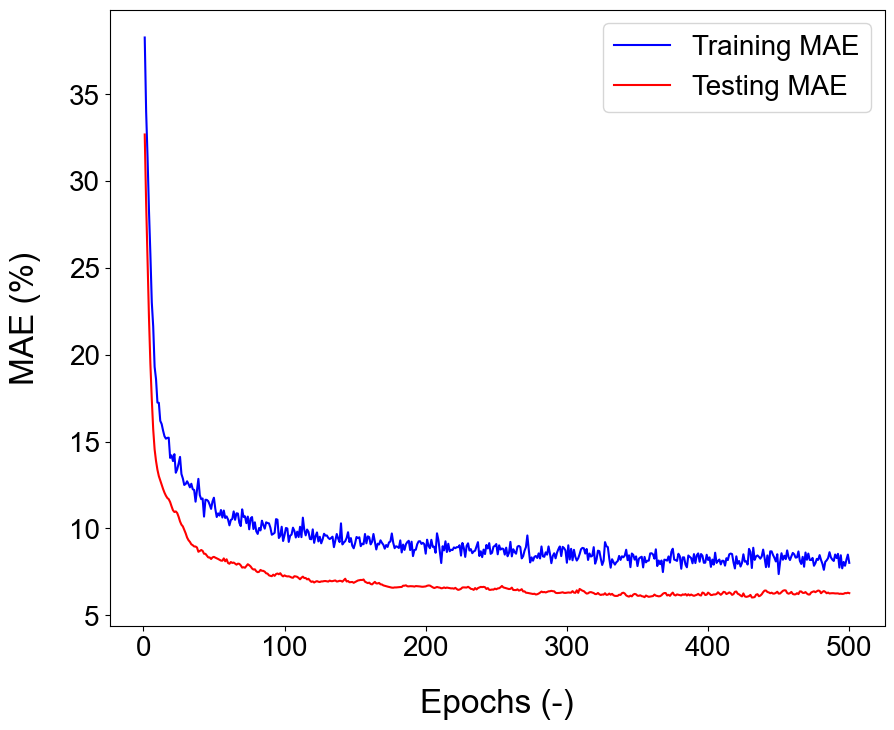

In [8]:
# Extract training and validation MAE from the history object
train_mae = [x * 100 for x in history_test.history['mae']]
val_mae = [x * 100 for x in history_test.history['val_mae']]
epochs = range(1, len(train_mae) + 1)

# Plot the training and validation MAE
plt.figure(figsize=(10, 8))
plt.plot(epochs, train_mae, 'b', label='Training MAE')
plt.plot(epochs, val_mae, 'r', label='Testing MAE')
plt.xlabel('Epochs (-)', fontsize=24, fontname='Arial', labelpad=20)
plt.ylabel('MAE (%)', fontsize=24, fontname='Arial', labelpad=20)
plt.xticks(fontsize=20, fontname='Arial')
plt.yticks(fontsize=20, fontname='Arial')
plt.legend(prop={'family':'Arial', 'size':20})
plt.savefig('112823_ECL_MAE.png', dpi=300, format='png')

In [9]:
val_mae = history_test.history['val_mae']
print('Validation MAE at final epoch: ', val_mae[-1])

Validation MAE at final epoch:  0.0627812072634697


In [26]:
ann_predict = np.round(model.predict(x_test_normalized), 3)

# Ravel the arrays before creating the DataFrame
y_test_ravel = np.ravel(y_test)
ann_predict_ravel = np.ravel(ann_predict)

pd.DataFrame({'Test Value': y_test_ravel, 'Prediction': ann_predict_ravel})

1/1 [==============================] - 0s 145ms/step


,Test Value,Prediction
0,0.258,0.263
1,0.000,-0.005
2,0.280,0.283
3,0.000,0.072
4,0.000,-0.010
5,0.000,0.014
6,0.254,0.133
7,0.000,0.106
8,0.000,0.041
9,0.000,0.032


In [32]:
xx = np.linspace(0.25, 2, num=51)
yy = np.linspace(0, 100, num=51)
zz = np.linspace(200, 800, num=51)

X, Y, Z = np.meshgrid(xx, yy, zz)

X_flatten = X.reshape(-1)
Y_flatten = Y.reshape(-1)
Z_flatten = Z.reshape(-1)

# Normalization
NX = np.round(X_flatten / 2, 4)
NY = Y_flatten / 100
NZ = Z_flatten / 800

# Make coordinations
NXYZ = np.array([NX, NY, NZ]).T

# Model prediction
pred = model.predict(NXYZ)
pred = np.round(pred, 4)

4146/4146 [==============================] - 11s 3ms/step


In [40]:
# High OD Value Ratio
len(pred[pred>=0.05])/len(pred)

0.4195897505484316

In [31]:
# Combine the predicted resuluts with coordination
results = np.column_stack((NX, NY, NZ, pred))

# Convert the array to a Pandas DataFramea
df_results = pd.DataFrame(results, columns=['NX', 'NY', 'NZ', 'Prediction'])

# Save the DataFrame to a CSV file
df_results.to_csv('101023_ann_predicted_results.csv', index=False)

In [29]:
model.predict

<bound method Model.predict of <keras.engine.sequential.Sequential object at 0x000001DB1E08A9B0>>

In [12]:
## SHAP
import shap

explainer = shap.Explainer(model.predict, x_train_normalized)
shap_values = explainer(x_train_normalized)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


10/10 [==============================] - 0s 3ms/step


Exact explainer:  36%|███▌      | 29/81 [00:00<?, ?it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  38%|███▊      | 31/81 [00:10<00:05,  9.66it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  40%|███▉      | 32/81 [00:10<00:07,  6.61it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  41%|████      | 33/81 [00:10<00:08,  5.95it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  42%|████▏     | 34/81 [00:10<00:08,  5.42it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  43%|████▎     | 35/81 [00:11<00:08,  5.22it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  44%|████▍     | 36/81 [00:11<00:08,  5.08it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  46%|████▌     | 37/81 [00:11<00:08,  4.95it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  47%|████▋     | 38/81 [00:11<00:08,  4.94it/s]

10/10 [==============================] - 0s 4ms/step


Exact explainer:  48%|████▊     | 39/81 [00:11<00:08,  4.89it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  49%|████▉     | 40/81 [00:12<00:08,  4.90it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  51%|█████     | 41/81 [00:12<00:08,  4.92it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  52%|█████▏    | 42/81 [00:12<00:08,  4.82it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  53%|█████▎    | 43/81 [00:12<00:07,  4.79it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  54%|█████▍    | 44/81 [00:12<00:07,  4.86it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  56%|█████▌    | 45/81 [00:13<00:07,  4.92it/s]

10/10 [==============================] - 0s 4ms/step


Exact explainer:  57%|█████▋    | 46/81 [00:13<00:07,  4.75it/s]

10/10 [==============================] - 0s 5ms/step


Exact explainer:  58%|█████▊    | 47/81 [00:13<00:08,  4.25it/s]

10/10 [==============================] - 0s 4ms/step


Exact explainer:  59%|█████▉    | 48/81 [00:13<00:07,  4.37it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  60%|██████    | 49/81 [00:14<00:07,  4.50it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  62%|██████▏   | 50/81 [00:14<00:06,  4.62it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  63%|██████▎   | 51/81 [00:14<00:06,  4.66it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  64%|██████▍   | 52/81 [00:14<00:06,  4.74it/s]

11/11 [==============================] - 0s 3ms/step


Exact explainer:  65%|██████▌   | 53/81 [00:14<00:06,  4.61it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  67%|██████▋   | 54/81 [00:15<00:05,  4.71it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  68%|██████▊   | 55/81 [00:15<00:05,  4.71it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  69%|██████▉   | 56/81 [00:15<00:05,  4.75it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  70%|███████   | 57/81 [00:15<00:05,  4.75it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  72%|███████▏  | 58/81 [00:15<00:04,  4.82it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  73%|███████▎  | 59/81 [00:16<00:04,  4.83it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  74%|███████▍  | 60/81 [00:16<00:04,  4.81it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  75%|███████▌  | 61/81 [00:16<00:04,  4.87it/s]

10/10 [==============================] - 0s 6ms/step


Exact explainer:  77%|███████▋  | 62/81 [00:16<00:04,  4.66it/s]

10/10 [==============================] - 0s 5ms/step


Exact explainer:  78%|███████▊  | 63/81 [00:17<00:03,  4.57it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  79%|███████▉  | 64/81 [00:17<00:03,  4.69it/s]

10/10 [==============================] - 0s 4ms/step


Exact explainer:  80%|████████  | 65/81 [00:17<00:03,  4.55it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  81%|████████▏ | 66/81 [00:17<00:03,  4.65it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  83%|████████▎ | 67/81 [00:17<00:03,  4.60it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  84%|████████▍ | 68/81 [00:18<00:02,  4.61it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  85%|████████▌ | 69/81 [00:18<00:02,  4.58it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  86%|████████▋ | 70/81 [00:18<00:02,  4.67it/s]

10/10 [==============================] - 0s 4ms/step


Exact explainer:  88%|████████▊ | 71/81 [00:18<00:02,  4.63it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  89%|████████▉ | 72/81 [00:18<00:01,  4.68it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  90%|█████████ | 73/81 [00:19<00:01,  4.69it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  91%|█████████▏| 74/81 [00:19<00:01,  4.79it/s]

10/10 [==============================] - 0s 4ms/step


Exact explainer:  93%|█████████▎| 75/81 [00:19<00:01,  4.77it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  94%|█████████▍| 76/81 [00:19<00:01,  4.81it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  95%|█████████▌| 77/81 [00:19<00:00,  4.84it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  96%|█████████▋| 78/81 [00:20<00:00,  4.74it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  98%|█████████▊| 79/81 [00:20<00:00,  4.78it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer:  99%|█████████▉| 80/81 [00:20<00:00,  4.81it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer: 100%|██████████| 81/81 [00:20<00:00,  4.80it/s]

10/10 [==============================] - 0s 3ms/step


Exact explainer: 82it [00:21,  2.52it/s]                        


In [30]:
shap_values.max(axis=0)

.values =
array([0.18568321, 0.03145185, 0.09270166])

.base_values =
array([0.11874231])

.data =
array([1., 1., 1.])

In [31]:
shap_values.min(axis=0)

.values =
array([-0.15804145, -0.10353198, -0.07045672])

.base_values =
array([0.11874231])

.data =
array([0.125 , 0.    , 0.0625])

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored
set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


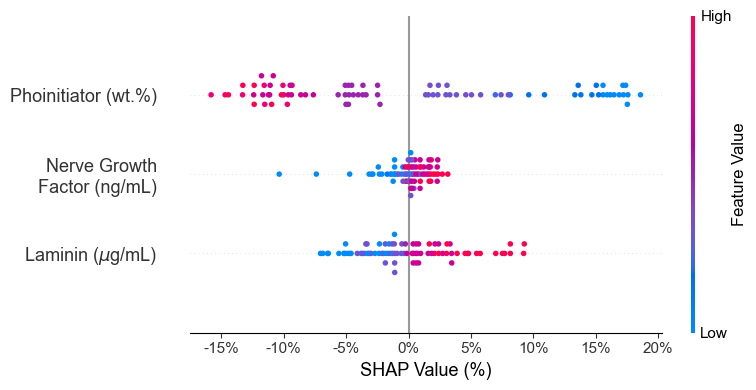

In [41]:
plt.rcParams['font.family'] = 'Arial'

# Initialize a new figure
fig = plt.figure()

shap.summary_plot(shap_values, x_train_normalized, 
                 feature_names=["Phoinitiator (wt.%)", "Nerve Growth\nFactor (ng/mL)", "Laminin ($\mu$g/mL)"], sort=False, show=False, plot_size=[8, 4], color_bar_label='Feature Value')

# Retrieve the current figure and axis
S = plt.gcf()
ax = plt.gca()

# Get the original x-axis tick labels
x_ticks = ax.get_xticks()

# Set the new tick labels, scaled by 100
ax.set_xticklabels([f"{tick * 100:.0f}%" for tick in x_ticks])

# Set the x-axis label
ax.set_xlabel("SHAP Value (%)")

# After setting the tick labels, show the plot
S.savefig('1108_SHAP_summ', dpi=300)
plt.show()

No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


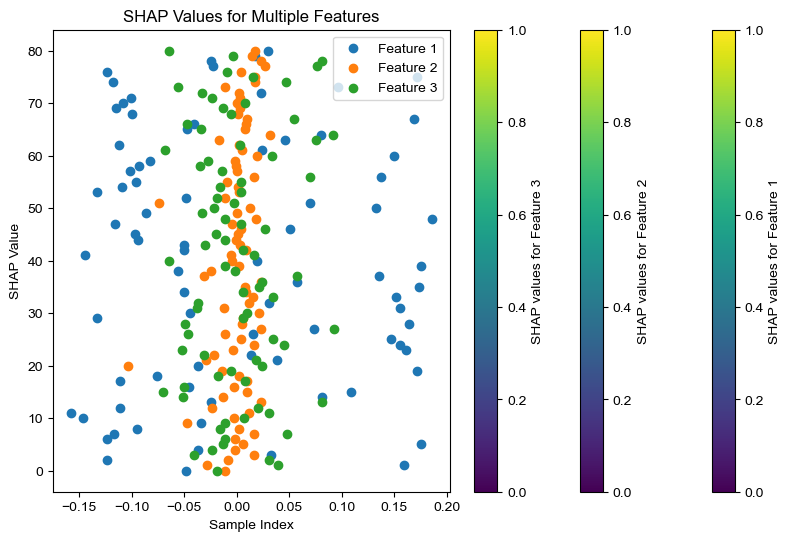

In [31]:
# Sample data
num_samples = shap_values.shape[0]
indices = np.arange(num_samples)  # X-axis: indices of samples
color_maps = ['Reds', 'Blues', 'Greens']  # Color maps for each feature

plt.figure(figsize=(10, 6))

# Loop through each feature to create layered scatter plots
for i in range(len(color_maps)):
    sc = plt.scatter(shap_values.values[:, i], indices, cmap=color_maps[i], label=f'Feature {i+1}')

    # Create a color bar for each feature
    plt.colorbar(sc, label=f'SHAP values for Feature {i+1}')

plt.xlabel('Sample Index')
plt.ylabel('SHAP Value')
plt.title('SHAP Values for Multiple Features')
plt.legend()
# plt.savefig('combined_shap_plot.png', dpi=300)
plt.show()

81

In [38]:
x_ticks

array([-0.2 , -0.15, -0.1 , -0.05,  0.  ,  0.05,  0.1 ,  0.15,  0.2 ,
        0.25])

In [15]:
batch_all[batch_all.columns[:3]]

,PHO (wt.%),NGF (ng/mL),LAM (ug/mL)
0,0.25,25,200
1,0.25,25,400
2,0.25,25,600
3,0.25,25,800
4,0.25,50,200
...,...,...,...
97,1.75,25,800
98,1.75,50,400
99,2.00,25,600
100,2.00,50,200


In [17]:
from scipy import stats
res, pvalue = stats.spearmanr(batch_all[batch_all.columns[:3]], batch_all['OD Value'])

In [19]:
pvalue

array([[0.00000000e+00, 6.54661345e-01, 7.89728576e-01, 4.30672304e-23],
       [6.54661345e-01, 0.00000000e+00, 6.62914057e-01, 8.19696760e-01],
       [7.89728576e-01, 6.62914057e-01, 0.00000000e+00, 6.37171949e-01],
       [4.30672304e-23, 8.19696760e-01, 6.37171949e-01, 0.00000000e+00]])

pvalue: [[0.00000000e+00 6.54661345e-01 7.89728576e-01 4.30672304e-23]
 [6.54661345e-01 0.00000000e+00 6.62914057e-01 8.19696760e-01]
 [7.89728576e-01 6.62914057e-01 0.00000000e+00 6.37171949e-01]
 [4.30672304e-23 8.19696760e-01 6.37171949e-01 0.00000000e+00]]


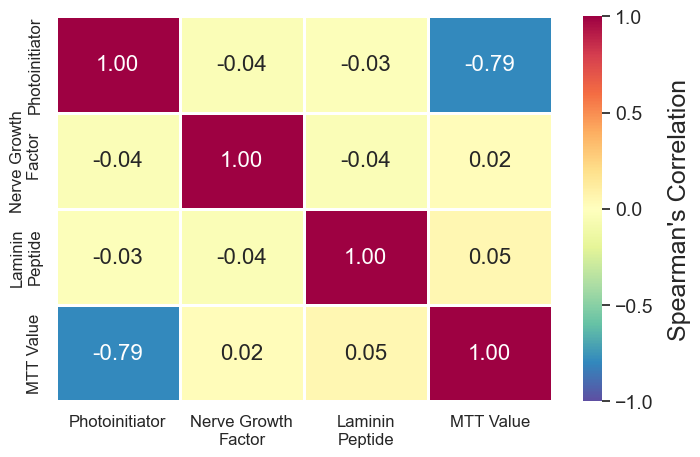

In [37]:
plt.close('all')

# Import the parckage
from scipy import stats
import seaborn as sns

# Spearmans' analysis
res, pvalue = stats.spearmanr(batch_all[batch_all.columns[:3]], batch_all['OD Value'])

print(f'pvalue: {pvalue}')

sns.set(rc={'font.family': 'Arial'})
dfs = pd.DataFrame({'Photoinitiator': batch_all['PHO (wt.%)'],
                   'Nerve Growth\nFactor': batch_all['NGF (ng/mL)'],
                   'Laminin\nPeptide': batch_all['LAM (ug/mL)'],
                   'MTT Value': batch_all['OD Value']})

corr = dfs.corr(method = 'spearman')

# Plot
new_cmap = sns.color_palette("Spectral_r", as_cmap=True)
heatmap = sns.heatmap(corr, annot=True, fmt=".2f", vmin=-1.0, cmap=new_cmap, linewidth=1, annot_kws={"fontsize": 16},
                      xticklabels=['Photoinitiator', 'Nerve Growth\nFactor', 'Laminin\nPeptide', 'MTT Value'],
                      yticklabels=['Photoinitiator', 'Nerve Growth\nFactor     ', 'Laminin\nPeptide', 'MTT Value'])

# for i in range(len(pvalue)):
#     for j in range(len(pvalue[0])):
#         if pvalue[i][j] < 0.01:
#             if i == j:
#                 heatmap_p.text(j+0.5, i+0.5, '0.00', ha='center', va='center', fontsize=16, fontname = 'Arial')
#             else:
#                 heatmap_p.text(j+0.5, i+0.5, '≤ 0.01', ha='center', va='center', fontsize=16, fontname='Arial')
#         elif pvalue[i][j] <= 0.5:
#             heatmap_p.text(j+0.5, i+0.5,f'{np.round(pvalue[i][j], decimals=2)}',ha='center', va='center', fontsize=16, color='w', fontname='Arial')
#         else:
#             heatmap_p.text(j+0.5, i+0.5,f'{np.round(pvalue[i][j], decimals=2)}',ha='center', va='center', fontsize=16, color='k', fontname='Arial')
                
# Adjust x, y ticks
# for tick in xticklabels:
  #  if tick.get_text() == 'pc-MXene':
   #     tick.set_text(r'$\mathit{pc}$' + '-MXene')

#for tick in yticklabels:
 #   if tick.get_text() == 'pc-MXene':
  #      tick.set_text(r'$\mathit{pc}$' + '-MXene')
        
heatmap.set_xticklabels(heatmap.get_xticklabels(), fontsize=12, rotation=0)
heatmap.set_yticklabels(heatmap.get_yticklabels(), fontsize=12, rotation=90, va='center')

# Adjust cbar
cbar = heatmap.collections[0].colorbar
cbar.ax.tick_params(labelsize=14)
ticks = [-1.0, -0.5, 0.0, 0.5, 1.0]
cbar.set_ticks(ticks)

F = plt.gcf()
F.set_size_inches(8, 5)
ax = plt.gca()
ax.set_ylabel("Spearman's Correlation", fontsize=18, loc='center', labelpad=-490, fontname="Arial")
F.savefig('1107_Spearmans', dpi=300)

In [10]:
pvalue

array([[0.00000000e+00, 6.54661345e-01, 7.89728576e-01, 4.30672304e-23],
       [6.54661345e-01, 0.00000000e+00, 6.62914057e-01, 8.19696760e-01],
       [7.89728576e-01, 6.62914057e-01, 0.00000000e+00, 6.37171949e-01],
       [4.30672304e-23, 8.19696760e-01, 6.37171949e-01, 0.00000000e+00]])

pvalue: [[0.00000000e+00 6.54661345e-01 7.89728576e-01 4.30672304e-23]
 [6.54661345e-01 0.00000000e+00 6.62914057e-01 8.19696760e-01]
 [7.89728576e-01 6.62914057e-01 0.00000000e+00 6.37171949e-01]
 [4.30672304e-23 8.19696760e-01 6.37171949e-01 0.00000000e+00]]


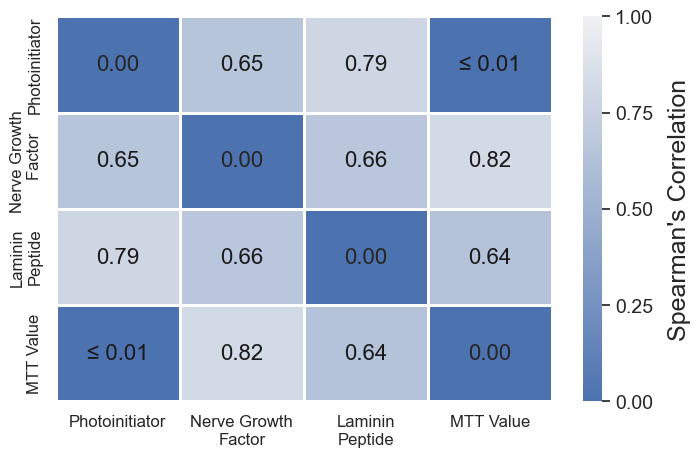

In [15]:
plt.close('all')

# Import the parckage
from scipy import stats
import seaborn as sns

# Spearmans' analysis
res, pvalue = stats.spearmanr(batch_all[batch_all.columns[:3]], batch_all['OD Value'])

print(f'pvalue: {pvalue}')

sns.set(rc={'font.family': 'Arial'})
dfs = pd.DataFrame({'Photoinitiator': batch_all['PHO (wt.%)'],
                   'Nerve Growth\nFactor': batch_all['NGF (ng/mL)'],
                   'Laminin\nPeptide': batch_all['LAM (ug/mL)'],
                   'MTT Value': batch_all['OD Value']})


# Plot
p_cmap = sns.color_palette("light:b_r", as_cmap=True)
heatmap_p = sns.heatmap(pvalue, annot=False, fmt=".2f", vmin=0.0,vmax=1.0,  cmap=p_cmap, linewidth=1, annot_kws={"fontsize": 16},
                      xticklabels=['Photoinitiator', 'Nerve Growth\nFactor', 'Laminin\nPeptide', 'MTT Value'],
                      yticklabels=['Photoinitiator', 'Nerve Growth\nFactor     ', 'Laminin\nPeptide', 'MTT Value'])

for i in range(len(pvalue)):
    for j in range(len(pvalue[0])):
        if pvalue[i][j] < 0.01:
            if i == j:
                heatmap_p.text(j+0.5, i+0.5, '0.00', ha='center', va='center', fontsize=16, fontname = 'Arial')
            else:
                heatmap_p.text(j+0.5, i+0.5, '≤ 0.01', ha='center', va='center', fontsize=16, color='k', fontname='Arial')
        elif pvalue[i][j] <= 0.5:
            heatmap_p.text(j+0.5, i+0.5,f'{np.round(pvalue[i][j], decimals=2)}',ha='center', va='center', fontsize=16, color='w', fontname='Arial')
        else:
            heatmap_p.text(j+0.5, i+0.5,f'{np.round(pvalue[i][j], decimals=2)}',ha='center', va='center', fontsize=16, color='k', fontname='Arial')
                
     
heatmap_p.set_xticklabels(heatmap_p.get_xticklabels(), fontsize=12, rotation=0)
heatmap_p.set_yticklabels(heatmap_p.get_yticklabels(), fontsize=12, rotation=90, va='center')

# Adjust cbar
cbarp = heatmap_p.collections[0].colorbar
cbarp.ax.tick_params(labelsize=14)
ticks = [0.0, 0.25, 0.50, 0.75, 1.00]
cbarp.set_ticks(ticks)

F = plt.gcf()
F.set_size_inches(8, 5)
ax = plt.gca()
ax.set_ylabel("Spearman's Correlation", fontsize=18, loc='center', labelpad=-490, fontname="Arial")
F.savefig('1107_Spearmans_p', dpi=300)